In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
PROJ_ROOT = os.pardir
data_dir = os.path.join(PROJ_ROOT, 'dataset')
train_imgs = os.path.join(data_dir, 'train_images')

In [3]:
train_path = Path(PROJ_ROOT, 'dataset', 'train_images')

ex_img = '0001TP_006900.png'

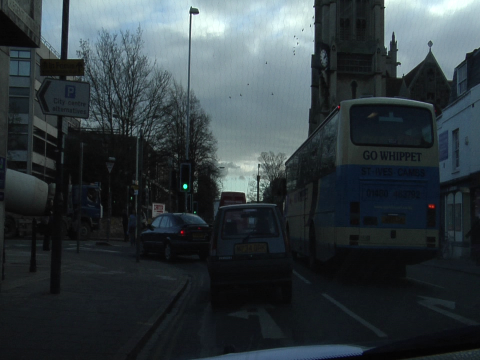

In [4]:
Image.open(train_path / ex_img)

## Augmentations

In [5]:
def img_tensor(img_path):
    """
    Read and decode image to tensor format.
    """
    img_str = tf.io.read_file(img_path)
    img = tf.image.decode_png(img_str, channels=3)
    print(img.shape)
    return img

In [6]:
def viz_augmentation(orig, aug):
    """
    Compare an original image to augmented image.
    """
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(orig)
    
    plt.subplot(1, 2, 2)
    plt.title('Augmented')
    plt.imshow(aug)

In [7]:
# convert to tensor
img = os.path.join(train_imgs, ex_img)
img = img_tensor(img)

(360, 480, 3)


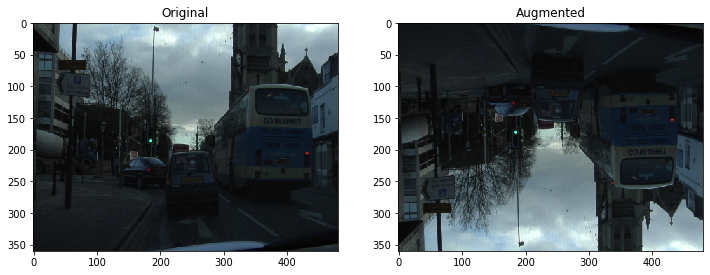

In [8]:
# flip vertically
vert_flip = tf.image.flip_up_down(img)

viz_augmentation(img, vert_flip)

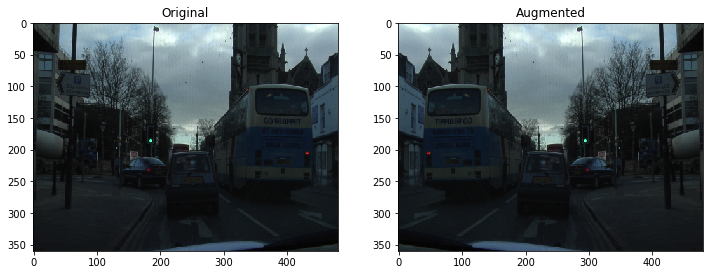

In [9]:
# flip horizontally
horiz_flip = tf.image.flip_left_right(img)

viz_augmentation(img, horiz_flip)

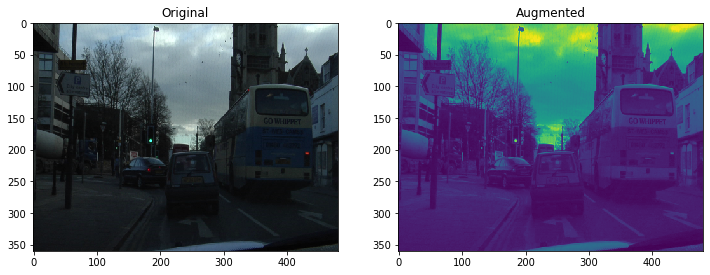

In [10]:
# grayscale image
gray = tf.image.rgb_to_grayscale(img)
# tf.squeeze(gray).shape = (360, 480)
viz_augmentation(img, tf.squeeze(gray))

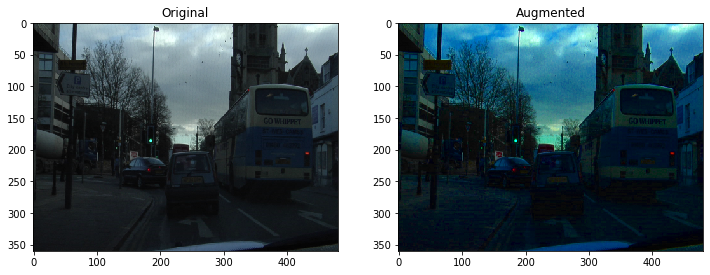

In [11]:
# saturate
saturate = tf.image.adjust_saturation(img, 4)

viz_augmentation(img, saturate)

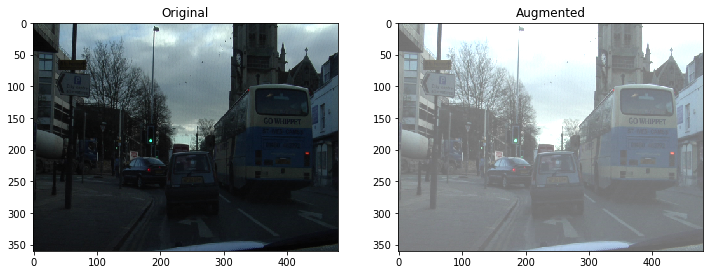

In [13]:
# random brightness
bright = tf.image.random_brightness(img, 0.8, seed=33)

viz_augmentation(img, bright)

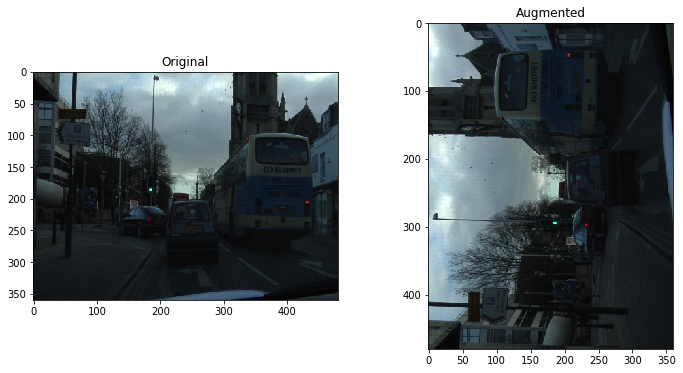

In [14]:
# rotate
rotate = tf.image.rot90(img)

viz_augmentation(img, rotate)

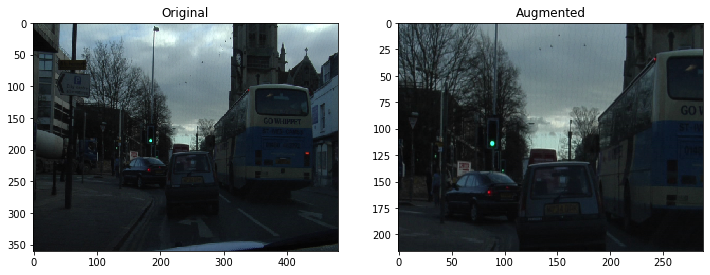

In [15]:
# crop
crop = tf.image.central_crop(img, 0.6)

viz_augmentation(img, crop)